In [1]:
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 


In [2]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

In [45]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=512, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.01, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
parser.add_argument("--in_channels", type=int, default=32, help="number of signal channels")
parser.add_argument("--out_channels", type=int, default=6, help="number of classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cuda:0


In [4]:
%%time
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    x = x.values
    y = y.iloc[:,1:].values
    return x, y
    

trainset_ = []
gt_ = []
for filename in tqdm(os.listdir('./newtrain')):
    if 'data' in filename:
        data_file_name = os.path.join('./newtrain', filename)
        id = filename.split('.')[0]
        events_file_name = os.path.join('./newtrain', '_'.join(id.split('_')[:-1]) + '_events.csv')
        x, y = read_csv(data_file_name, events_file_name)
        trainset_.append(x.T.astype(np.float32))
        gt_.append(y.T.astype(np.float32))

  0%|          | 0/176 [00:00<?, ?it/s]

CPU times: total: 44.2 s
Wall time: 56.5 s


In [46]:
# train test split
valid_dataset = trainset_[-2:]
valid_gt = gt_[-2:]
trainset = trainset_[:-2]
gt = gt_[:-2]

In [47]:
#get mean and standard deviation from training data
train_data = np.concatenate([d for d in trainset], axis=1)
mean = np.mean(train_data, axis=1)
print(mean.shape)
std = np.std(train_data, axis=1)
print(std.shape)

(32,)
(32,)


In [48]:

%%time
class EEGSignalDataset(Dataset):
    def __init__(self, data, gt): #, m=m, s=s
        self.eps = 1e-7
        self.data = np.concatenate([d for d in data], axis=1)
        self.gt = np.concatenate([d for d in gt], axis=1)
        
        for dt_n in range(len(self.data)):
            self.data[dt_n] -= mean[dt_n]
            self.data[dt_n] /= std[dt_n]+self.eps
        #print(self.data.shape)
        #print(self.gt.shape)
    
    def __getitem__(self, i):
        if i >= opt.in_len: 
            return self.data[:,i-opt.in_len:i], self.gt[:,i]
        else:
            raw_data = self.data[:,0:i]
            pad = opt.in_len - i
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)
            return raw_data, self.gt[:,i]
            
    def __len__(self):
        return len(self.data[0])
#load training dataset
if __name__ == '__main__':
    dataset = EEGSignalDataset(trainset, gt) 
    dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                           num_workers = 0, shuffle=True)
    print(len(dataset))

14601012
CPU times: total: 781 ms
Wall time: 1.04 s


In [57]:
#build CNN Module
class NNet(nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, 6, 1),
            nn.Flatten(),
            nn.Sigmoid()
        ))
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        return self.net(x)

In [58]:
# train cnn model
nnet = NNet()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(),lr=0.001, betas=(0.5, 0.99))
loss_his, train_loss = [], []
nnet.train()
for epoch in range(opt.n_epochs):
    p_bar = tqdm(dataloader)
    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        pred = nnet(x)
        loss = loss_fnc(pred, y)
        adam.zero_grad()
        loss.backward()
        adam.step()
        train_loss.append(loss.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, opt.n_epochs, loss_his[-1]))
    
torch.save(nnet.state_dict(), 'model_final.pt')

  0%|          | 0/28518 [00:00<?, ?it/s]

[Epoch 1/1] [Loss: 0.0417940616607666]


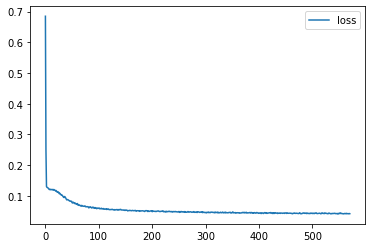

In [75]:
#torch.onnx.export(nnet, x, 'eeg_cnn.onnx', input_names=["eeg_signal"], output_names=["hand_events"])
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

In [63]:
#test model
nnet = NNet()
nnet.to(device)
nnet.load_state_dict(torch.load('model_final.pt'))
if __name__ == '__main__':
    testset = EEGSignalDataset(valid_dataset, valid_gt) 
    testloader = DataLoader(testset, batch_size = opt.batch_size,\
                                           num_workers = opt.n_cpu, shuffle=False)
    nnet.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x, _ in tqdm(testloader):
            x = x.to(device)
            pred = nnet(x).detach().cpu().numpy()
            y_pred.append(pred)
            y_true.append(_)

  0%|          | 0/500 [00:00<?, ?it/s]

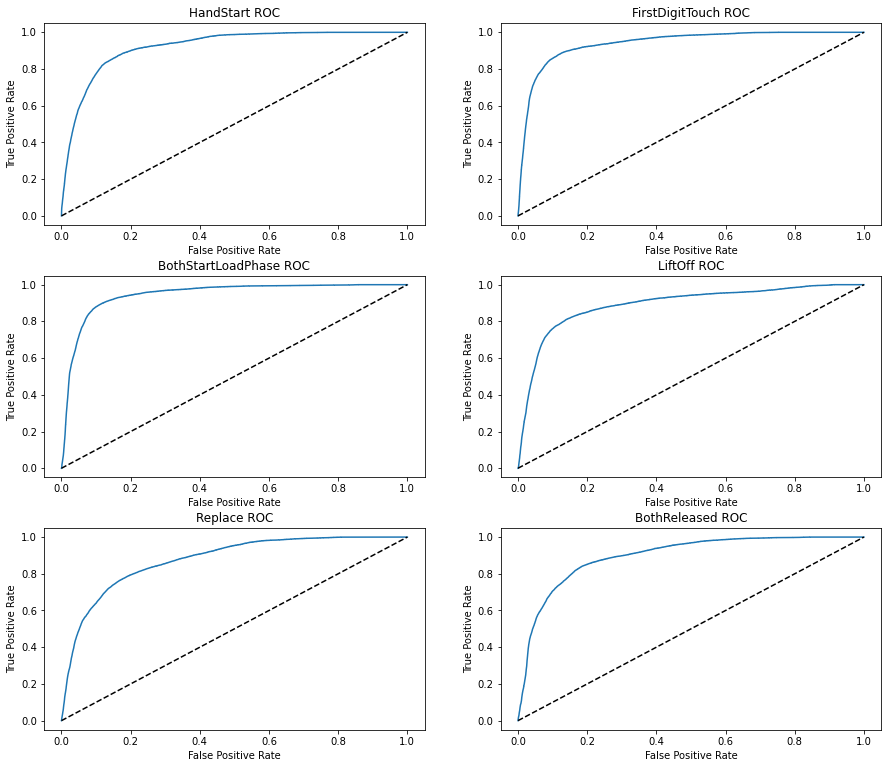

Area Under ROC Curve:  0.9118277495429798


In [74]:
y_pred_concat = np.concatenate(y_pred, axis=0)
y_true_concat = np.concatenate(y_true, axis=0)

def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    plt.subplots_adjust(wspace=None, hspace=0.25)
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_ylabel("True Positive Rate")
        ax.set_xlabel("False Positive Rate")
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

    plt.show()
    


plot_roc(y_true_concat.T, y_pred_concat.T)
print('Area Under ROC Curve: ', metrics.roc_auc_score(y_true_concat, y_pred_concat))